In [1]:
import warnings
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

warnings.filterwarnings("ignore")
plt.style.use("default")
import os, sys
from shapely.geometry import mapping
import geopandas as gpd
import texttable
import global_land_mask
import cartopy.crs as ccrs

sys.path.append("../CMIP6-downscale/")
from CMIP6_ridgeplot import CMIP6_ridgeplot
from xclim import ensembles
from datetime import datetime
import seaborn as sns
from CMIP6_IO import CMIP6_IO

import pyproj

pyproj.datadir.set_data_dir("/home/sam/miniconda3/envs/actea-3.9/share/proj/")
pyproj.datadir.get_data_dir()
plt.style.use("default")
sns.set(font_scale=1.1, style="whitegrid")
io = CMIP6_IO()

Plot PAR as either monthly distributions per time periods (e.g. 1993-2010), or plot heatmaps showing the difference in PAR for an area per month and how the values change into the future.

FRA to SFO 26.10.2022, modified 20.04.2023


In [2]:
def get_LME_records():
    lme_file = "gs://actea-shared/Shapefiles/LME66/LMEs66.shp"
    return gpd.read_file(lme_file)


def get_LME_records_180():
    lme_file = "gs://actea-shared/Shapefiles/LME66_180/LME66_180.shp"
    return gpd.read_file(lme_file)


def create_colors(N):
    color = iter(cm.tab20b(np.linspace(0, 1, N)))
    return [next(color) for c in range(N)]


def get_data_within_LME(ds, LME):
    # Extract the polygon defining the boundaries of the LME
    # if LME=="Barents Sea":
    shdf = get_LME_records()
    # elif LME=="Northern Bering - Chukchi Seas":
    #    shdf = get_LME_records_180()
    # else:
    #    raise ValueError("LME not found")

    shdf_sel = shdf[shdf["LME_NAME"] == LME]
    clipped = None

    ds = ds.rio.write_crs("epsg:4326", inplace=True)
    ds = ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)

    clipped = ds.rio.clip(geometries=shdf_sel.geometry.apply(mapping), crs=ds.rio.crs)
    area_calc = shdf_sel["geometry"].to_crs({"proj": "cea"})

    print(f"Total area of LME {LME} in km2 {area_calc.area / 10**6}")
    # Rioxarray requires x and y dimensions - we convert these back to lon and lat later.
    # We also add the projection (lat-lon) so that rioxarray can do the clipping of the data according to the
    # shapefile.

    return clipped

In [3]:
def convert_to_180(ds):
    if len(ds.lon.dims) == 2:
        ds = (ds.assign_coords(x=(((ds.x + 180) % 360) - 180))).sortby("x")

        ds = ds.assign_coords(y=ds.lat[:, 0].values, x=ds.x)
        ds = ds.drop(["lat", "lon"])
        ds = ds.rename({"y": "lat", "x": "lon"})
    else:
        ds = (ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))).sortby("lon")
    return ds


def convert_time(ds):
    if not ds.indexes["time"].dtype in ["datetime64[ns]"]:
        time_objects = ds.indexes["time"].to_datetimeindex()
        ds = ds.assign_coords({"time": time_objects})
        ds = xr.decode_cf(ds)

    return ds


def create_land_ocean_mask(cmip6_grid: xr.Dataset) -> xr.DataArray:
    print("[create_land_ocean_mask] Running create_land_ocean_mask")
    lon = cmip6_grid.lon.values
    lat = cmip6_grid.lat.values
    lon_180 = xr.where(lon > 180, lon - 360, lon)
    lon_grid, lat_grid = np.meshgrid(lon_180, lat)
    mask_data = global_land_mask.globe.is_ocean(lat_grid, lon_grid).astype(int)

    return xr.DataArray(mask_data, coords={"lat": lat, "lon": lon}, dims=["lat", "lon"])


def get_area_averaged_ds(
    ds, model, scenario, ensemble_id, var_name, LME, models_dict, start_time, end_time
):
    if isinstance(ds, xr.Dataset):
        print(ds)
        ds = convert_to_180(ds)
        print(ds)
        ds = ds.sel(time=slice(start_time, end_time))
        ds = convert_time(ds)

        # Convert from kg/m-3 to mg/m-3
        if var_name == "chl":
            ds[f"{var_name}_mean"] = ds[f"{var_name}_mean"] * 1.0e6

        ds_lme = get_data_within_LME(ds, LME)
        ds_lme["mask"] = create_land_ocean_mask(ds_lme.isel(time=0))
        ds_lme = ds_lme.where(ds_lme.mask == 1)

        model_info = {}
        model_info["model_name"] = model
        model_info["model_scenario"] = scenario
        model_info["model_ensemble_id"] = ensemble_id
        model_info["model_var"] = var_name
        model_info["LME"] = LME
        key = "{}_{}_{}_{}".format(model, ensemble_id, scenario, var_name)
        models_dict[key] = model_info
        return models_dict, ds_lme
    else:
        return models_dict, None

In [4]:
def create_summary_table(dict_of_models, LME):
    table = texttable.Texttable()
    table.set_cols_align(["c", "c", "c", "c", "c", "c", "c"])
    table.set_cols_valign(["t", "t", "m", "m", "m", "m", "b"])

    table.header(["LME", "Model", "Scenario", "ID", "Var", "CMIP6 min", "CMIP6 max"])
    for key in dict_of_models.keys():
        model = dict_of_models[key]

        table.add_row(
            [
                LME,
                model["model_name"],
                model["model_scenario"],
                model["model_ensemble_id"],
                str(model["model_var"]),
                str(model["model_var"]),
                str(model["model_var"]),
            ]
        )

    table.set_cols_width([30, 30, 20, 20, 10, 10, 10])
    print(table.draw() + "\n")

[CMIP6_IO] Opening file actea-shared/light/ncfiles/ensemble/CMIP6_ensemble_stats_ssp245_par.nc


<xarray.Dataset>
Dimensions:    (lon: 360, lat: 25, time: 8709)
Coordinates:
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat        (lat) float64 60.5 61.5 62.5 63.5 64.5 ... 81.5 82.5 83.5 84.5
  * time       (time) datetime64[ns] 1979-01-16T12:00:00 ... 2099-12-16T20:00:00
Data variables:
    par_mean   (time, lat, lon) float32 ...
    par_stdev  (time, lat, lon) float32 ...
    par_max    (time, lat, lon) float32 ...
    par_min    (time, lat, lon) float32 ...
Attributes:
    title:        Test
    description:  Created for grid file:
    history:      Created 2023-09-16 22:54:41.721517\n[2023-10-04 19:41:09] :...
    link:         https://github.com/trondkr/model2roms
<xarray.Dataset>
Dimensions:    (lon: 360, lat: 25, time: 8709)
Coordinates:
  * lon        (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat        (lat) float64 60.5 61.5 62.5 63.5 64.5 ... 81.5 82.5 83.5 84.5
  * time       (time) datetime64[ns] 1979-01-16T

<Figure size 640x480 with 0 Axes>

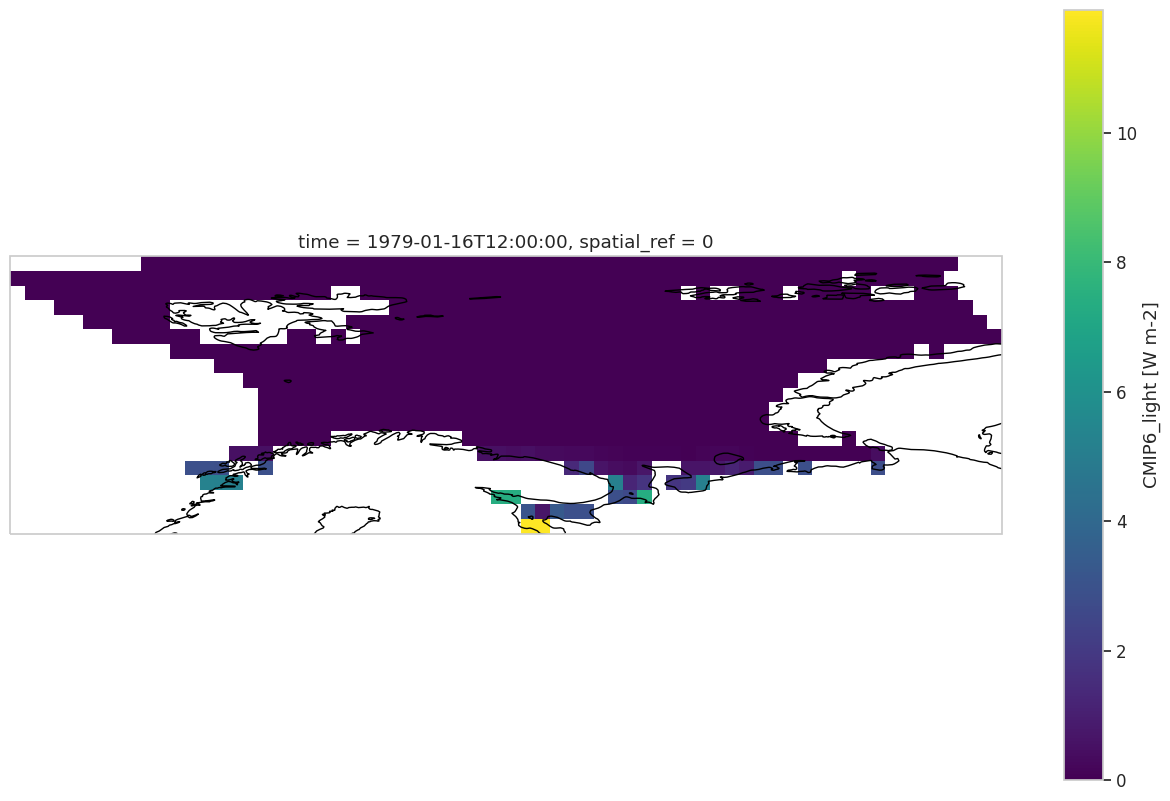

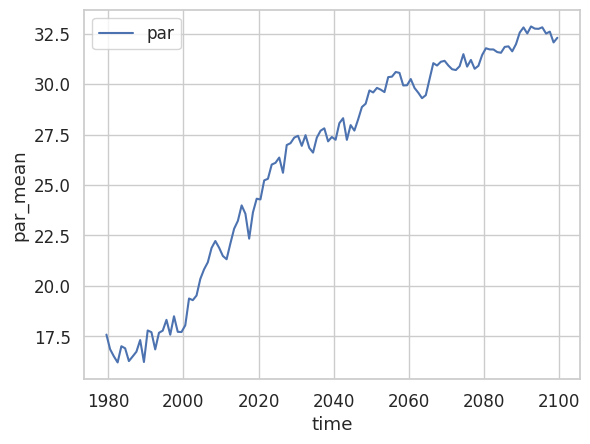

[CMIP6_IO] Opening file actea-shared/light/ncfiles/ensemble/CMIP6_ensemble_stats_ssp585_par.nc
<xarray.Dataset>
Dimensions:    (lon: 360, lat: 25, time: 8709)
Coordinates:
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat        (lat) float64 60.5 61.5 62.5 63.5 64.5 ... 81.5 82.5 83.5 84.5
  * time       (time) datetime64[ns] 1979-01-16T12:00:00 ... 2099-12-16T20:00:00
Data variables:
    par_mean   (time, lat, lon) float32 ...
    par_stdev  (time, lat, lon) float32 ...
    par_max    (time, lat, lon) float32 ...
    par_min    (time, lat, lon) float32 ...
Attributes:
    title:        Test
    description:  Created for grid file:
    history:      Created 2023-09-17 08:53:30.099455\n[2023-10-05 16:16:42] :...
    link:         https://github.com/trondkr/model2roms
<xarray.Dataset>
Dimensions:    (lon: 360, lat: 25, time: 8709)
Coordinates:
  * lon        (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat        (lat) float64 60

<Figure size 640x480 with 0 Axes>

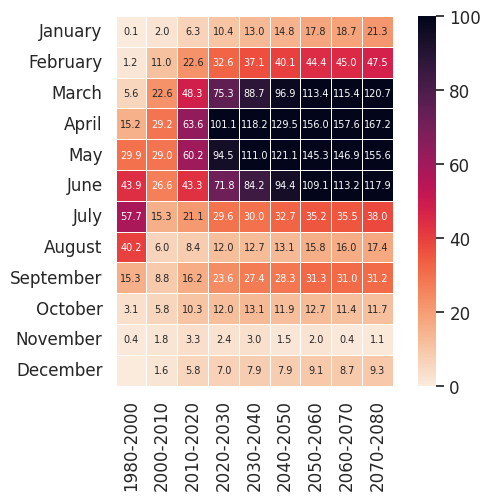

<Figure size 640x480 with 0 Axes>

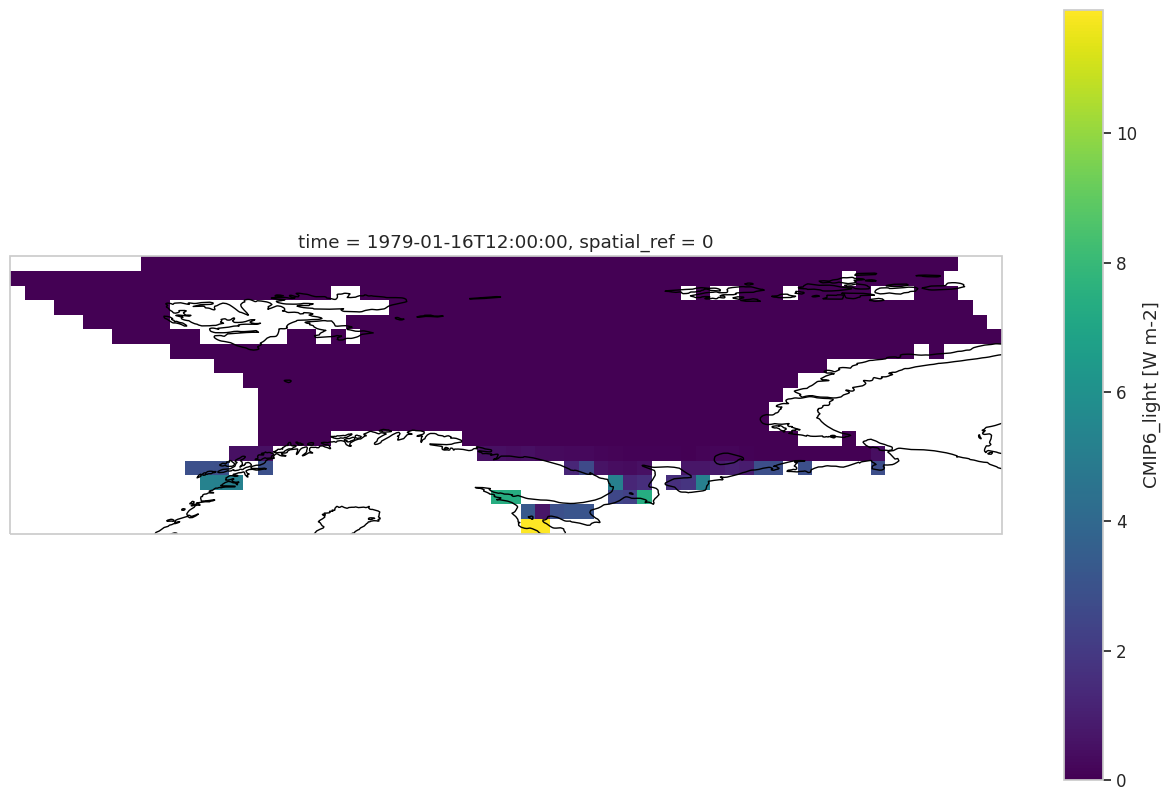

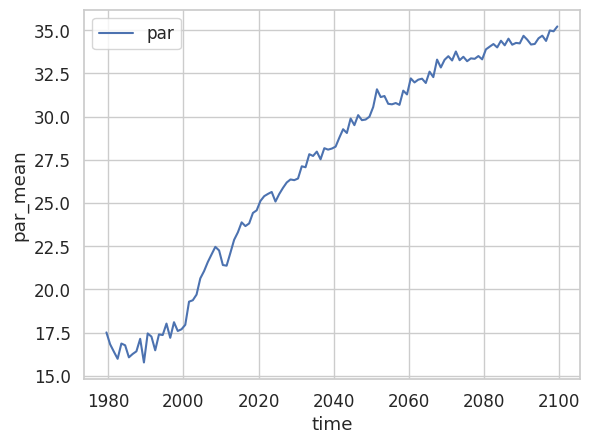

[CMIP6_IO] Opening file actea-shared/light/ncfiles/ensemble/CMIP6_ensemble_stats_ssp245_par.nc
<xarray.Dataset>
Dimensions:    (lon: 360, lat: 25, time: 8709)
Coordinates:
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat        (lat) float64 60.5 61.5 62.5 63.5 64.5 ... 81.5 82.5 83.5 84.5
  * time       (time) datetime64[ns] 1979-01-16T12:00:00 ... 2099-12-16T20:00:00
Data variables:
    par_mean   (time, lat, lon) float32 ...
    par_stdev  (time, lat, lon) float32 ...
    par_max    (time, lat, lon) float32 ...
    par_min    (time, lat, lon) float32 ...
Attributes:
    title:        Test
    description:  Created for grid file:
    history:      Created 2023-09-16 22:54:41.721517\n[2023-10-04 19:41:09] :...
    link:         https://github.com/trondkr/model2roms
<xarray.Dataset>
Dimensions:    (lon: 360, lat: 25, time: 8709)
Coordinates:
  * lon        (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat        (lat) float64 60

<Figure size 640x480 with 0 Axes>

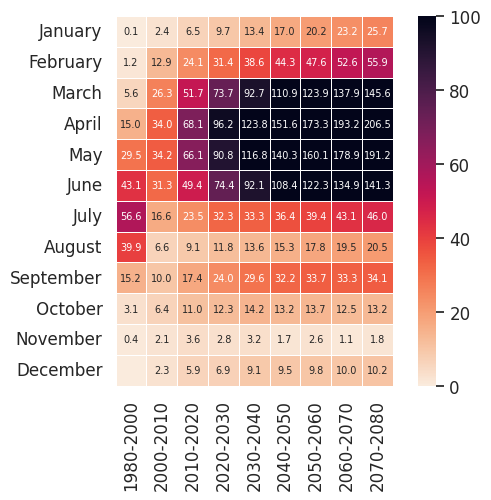

<Figure size 640x480 with 0 Axes>

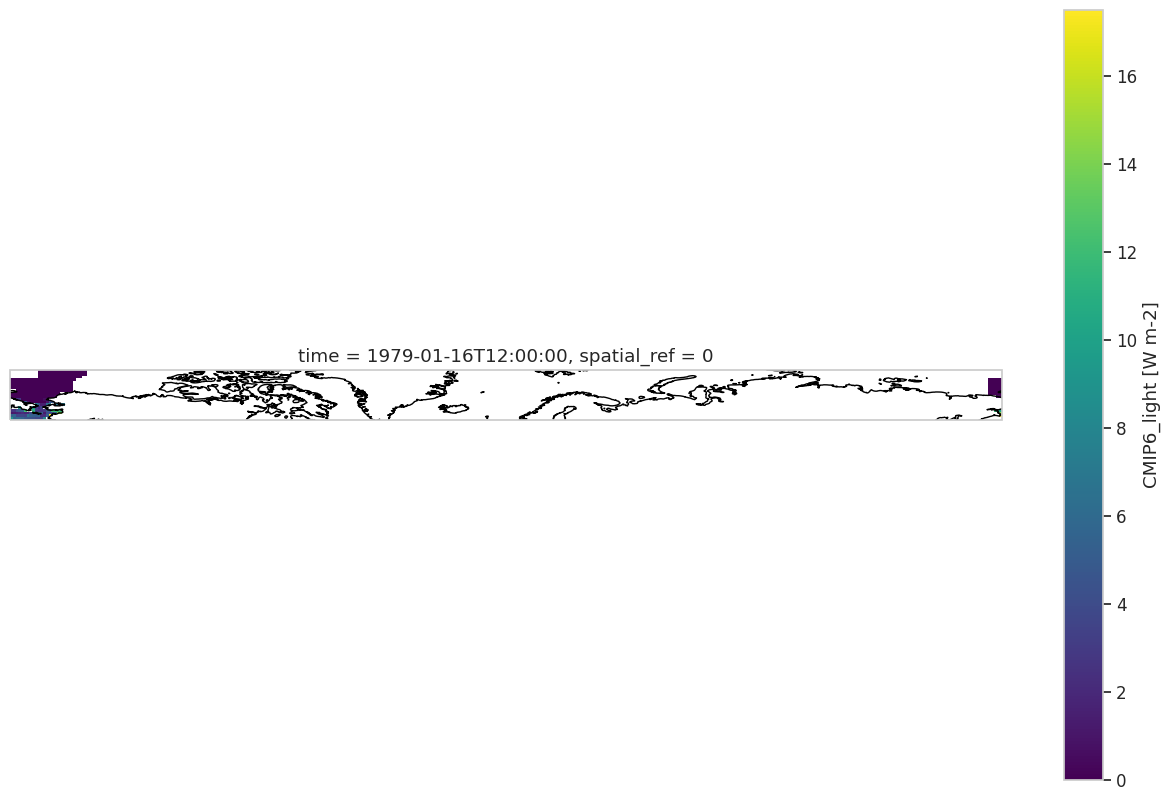

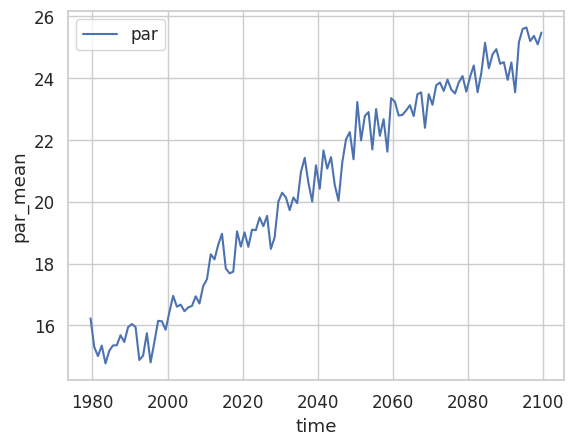

[CMIP6_IO] Opening file actea-shared/light/ncfiles/ensemble/CMIP6_ensemble_stats_ssp585_par.nc
<xarray.Dataset>
Dimensions:    (lon: 360, lat: 25, time: 8709)
Coordinates:
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat        (lat) float64 60.5 61.5 62.5 63.5 64.5 ... 81.5 82.5 83.5 84.5
  * time       (time) datetime64[ns] 1979-01-16T12:00:00 ... 2099-12-16T20:00:00
Data variables:
    par_mean   (time, lat, lon) float32 ...
    par_stdev  (time, lat, lon) float32 ...
    par_max    (time, lat, lon) float32 ...
    par_min    (time, lat, lon) float32 ...
Attributes:
    title:        Test
    description:  Created for grid file:
    history:      Created 2023-09-17 08:53:30.099455\n[2023-10-05 16:16:42] :...
    link:         https://github.com/trondkr/model2roms
<xarray.Dataset>
Dimensions:    (lon: 360, lat: 25, time: 8709)
Coordinates:
  * lon        (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat        (lat) float64 60

<Figure size 640x480 with 0 Axes>

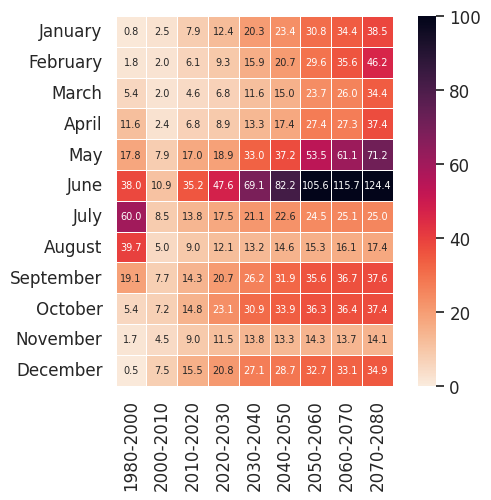

<Figure size 640x480 with 0 Axes>

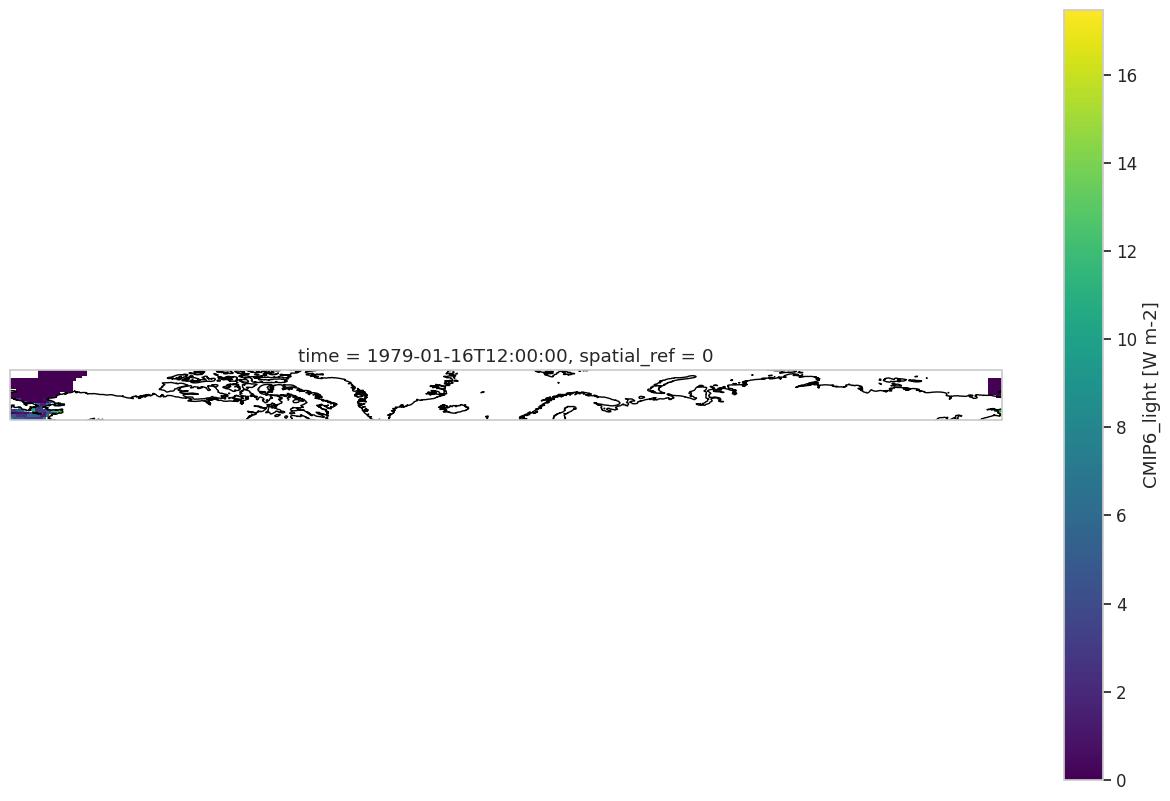

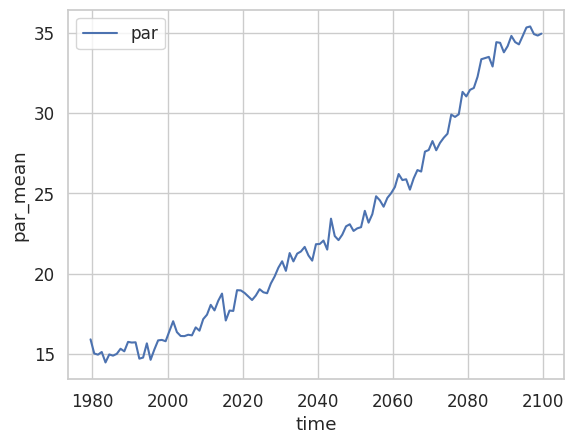

[CMIP6_IO] Opening file actea-shared/light/ncfiles/ensemble/CMIP6_ensemble_stats_ssp245_uv.nc
<xarray.Dataset>
Dimensions:   (lon: 360, lat: 25, time: 8709)
Coordinates:
  * lon       (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat       (lat) float64 60.5 61.5 62.5 63.5 64.5 ... 81.5 82.5 83.5 84.5
  * time      (time) datetime64[ns] 1979-01-16T12:00:00 ... 2099-12-16T20:00:00
Data variables:
    uv_mean   (time, lat, lon) float32 ...
    uv_stdev  (time, lat, lon) float32 ...
    uv_max    (time, lat, lon) float32 ...
    uv_min    (time, lat, lon) float32 ...
Attributes:
    title:        Test
    description:  Created for grid file:
    history:      Created 2023-09-16 22:54:41.743558\n[2023-09-30 17:22:45] :...
    link:         https://github.com/trondkr/model2roms
<xarray.Dataset>
Dimensions:   (lon: 360, lat: 25, time: 8709)
Coordinates:
  * lon       (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat       (lat) float64 60.5 61.5 62.5

<Figure size 640x480 with 0 Axes>

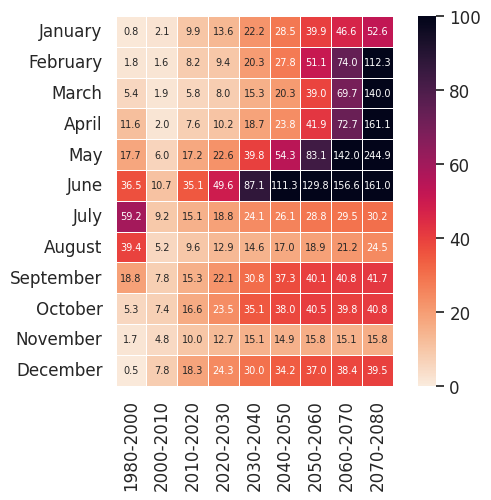

<Figure size 640x480 with 0 Axes>

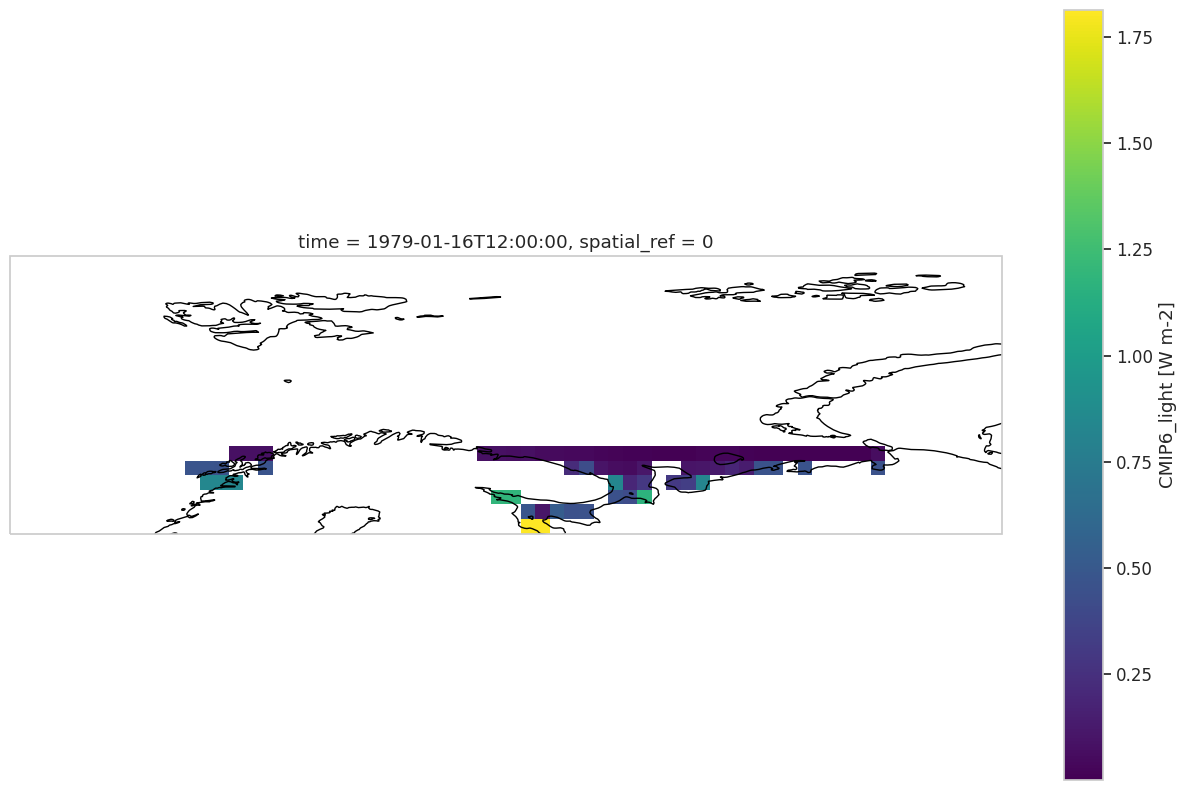

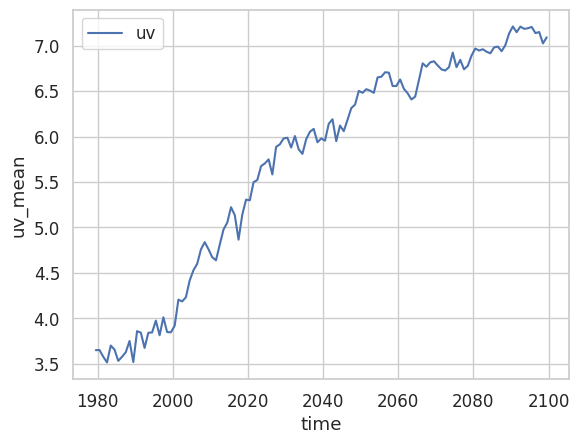

[CMIP6_IO] Opening file actea-shared/light/ncfiles/ensemble/CMIP6_ensemble_stats_ssp585_uv.nc
<xarray.Dataset>
Dimensions:   (lon: 360, lat: 25, time: 8709)
Coordinates:
  * lon       (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat       (lat) float64 60.5 61.5 62.5 63.5 64.5 ... 81.5 82.5 83.5 84.5
  * time      (time) datetime64[ns] 1979-01-16T12:00:00 ... 2099-12-16T20:00:00
Data variables:
    uv_mean   (time, lat, lon) float32 ...
    uv_stdev  (time, lat, lon) float32 ...
    uv_max    (time, lat, lon) float32 ...
    uv_min    (time, lat, lon) float32 ...
Attributes:
    title:        Test
    description:  Created for grid file:
    history:      Created 2023-09-17 08:53:30.125631\n[2023-09-30 17:26:21] :...
    link:         https://github.com/trondkr/model2roms
<xarray.Dataset>
Dimensions:   (lon: 360, lat: 25, time: 8709)
Coordinates:
  * lon       (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat       (lat) float64 60.5 61.5 62.5

<Figure size 640x480 with 0 Axes>

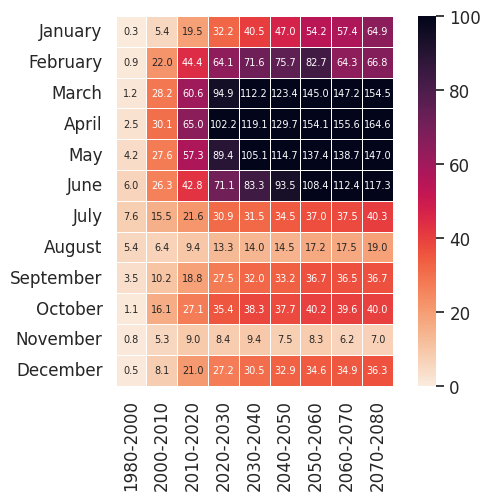

<Figure size 640x480 with 0 Axes>

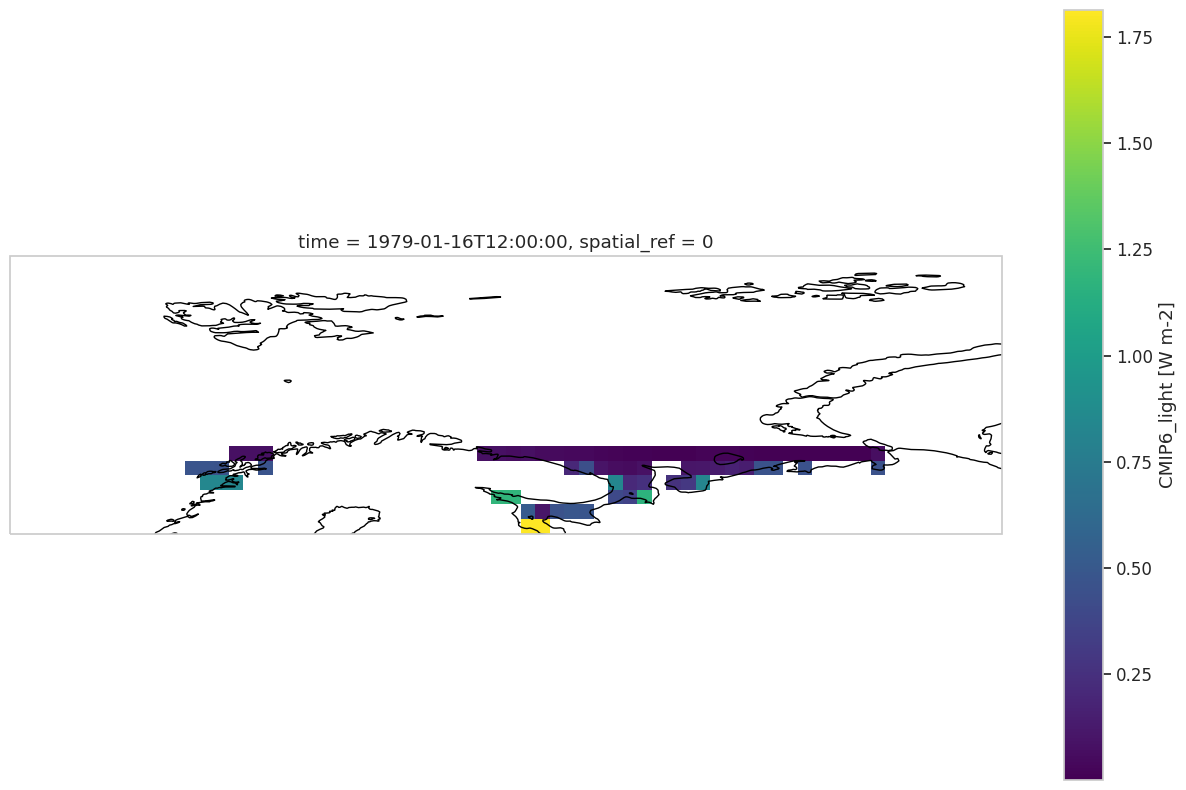

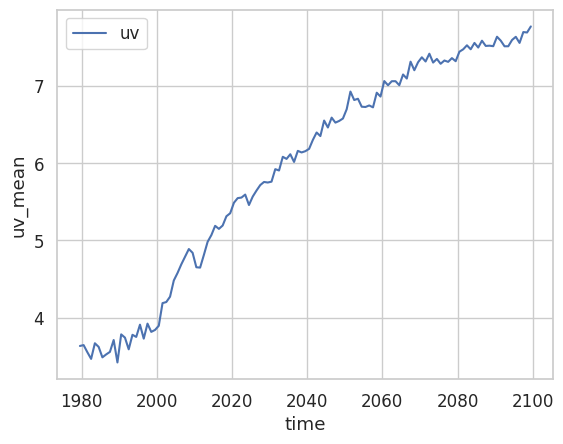

[CMIP6_IO] Opening file actea-shared/light/ncfiles/ensemble/CMIP6_ensemble_stats_ssp245_uv.nc
<xarray.Dataset>
Dimensions:   (lon: 360, lat: 25, time: 8709)
Coordinates:
  * lon       (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat       (lat) float64 60.5 61.5 62.5 63.5 64.5 ... 81.5 82.5 83.5 84.5
  * time      (time) datetime64[ns] 1979-01-16T12:00:00 ... 2099-12-16T20:00:00
Data variables:
    uv_mean   (time, lat, lon) float32 ...
    uv_stdev  (time, lat, lon) float32 ...
    uv_max    (time, lat, lon) float32 ...
    uv_min    (time, lat, lon) float32 ...
Attributes:
    title:        Test
    description:  Created for grid file:
    history:      Created 2023-09-16 22:54:41.743558\n[2023-09-30 17:22:45] :...
    link:         https://github.com/trondkr/model2roms
<xarray.Dataset>
Dimensions:   (lon: 360, lat: 25, time: 8709)
Coordinates:
  * lon       (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat       (lat) float64 60.5 61.5 62.5

<Figure size 640x480 with 0 Axes>

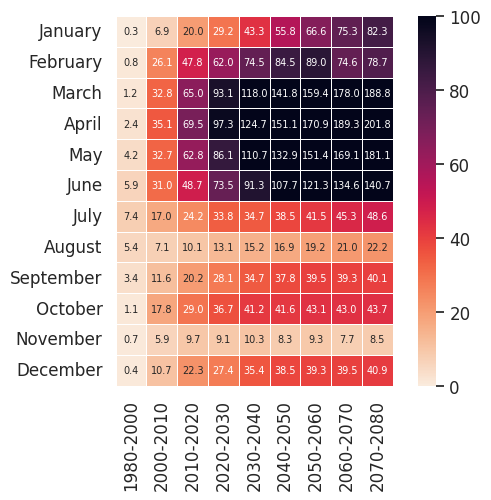

<Figure size 640x480 with 0 Axes>

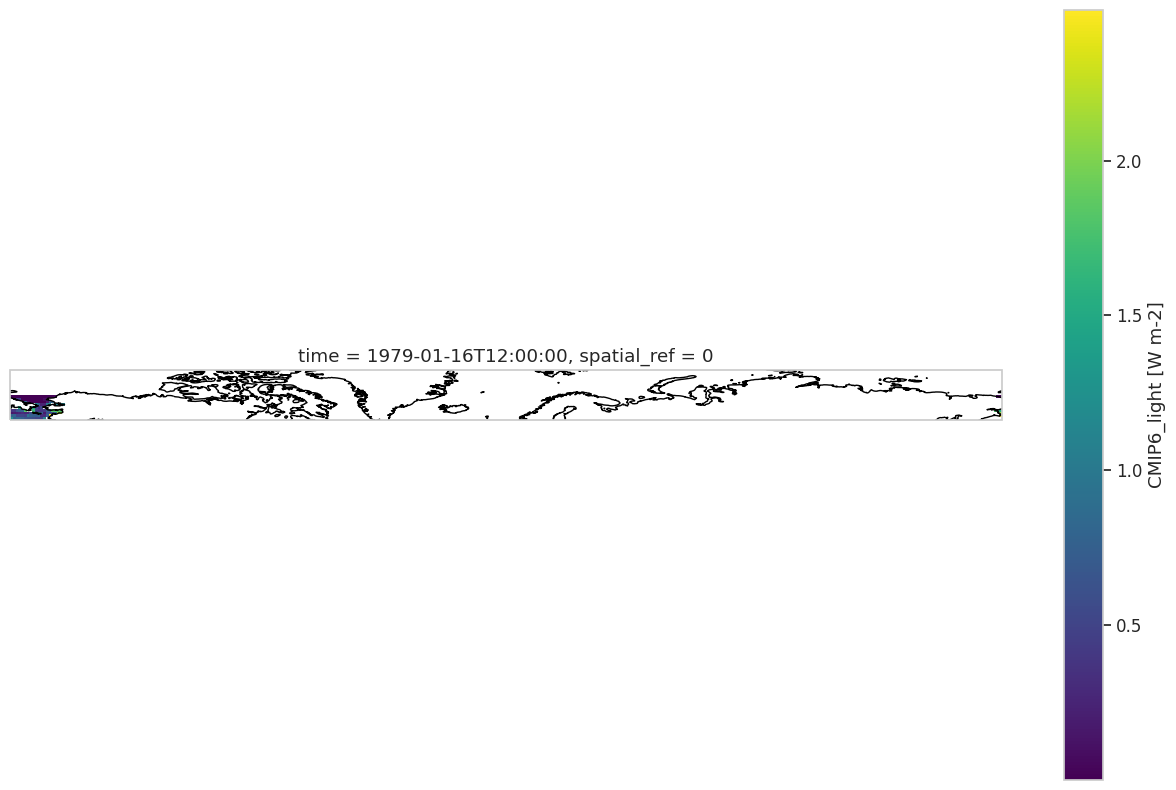

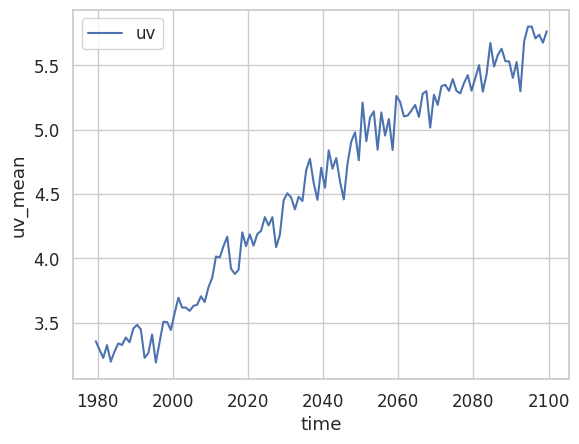

[CMIP6_IO] Opening file actea-shared/light/ncfiles/ensemble/CMIP6_ensemble_stats_ssp585_uv.nc
<xarray.Dataset>
Dimensions:   (lon: 360, lat: 25, time: 8709)
Coordinates:
  * lon       (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat       (lat) float64 60.5 61.5 62.5 63.5 64.5 ... 81.5 82.5 83.5 84.5
  * time      (time) datetime64[ns] 1979-01-16T12:00:00 ... 2099-12-16T20:00:00
Data variables:
    uv_mean   (time, lat, lon) float32 ...
    uv_stdev  (time, lat, lon) float32 ...
    uv_max    (time, lat, lon) float32 ...
    uv_min    (time, lat, lon) float32 ...
Attributes:
    title:        Test
    description:  Created for grid file:
    history:      Created 2023-09-17 08:53:30.125631\n[2023-09-30 17:26:21] :...
    link:         https://github.com/trondkr/model2roms
<xarray.Dataset>
Dimensions:   (lon: 360, lat: 25, time: 8709)
Coordinates:
  * lon       (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat       (lat) float64 60.5 61.5 62.5

<Figure size 640x480 with 0 Axes>

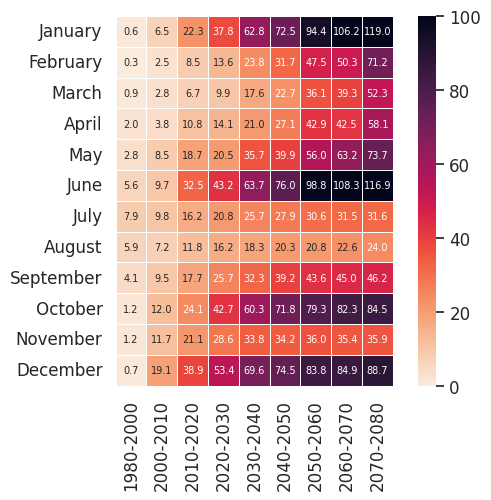

<Figure size 640x480 with 0 Axes>

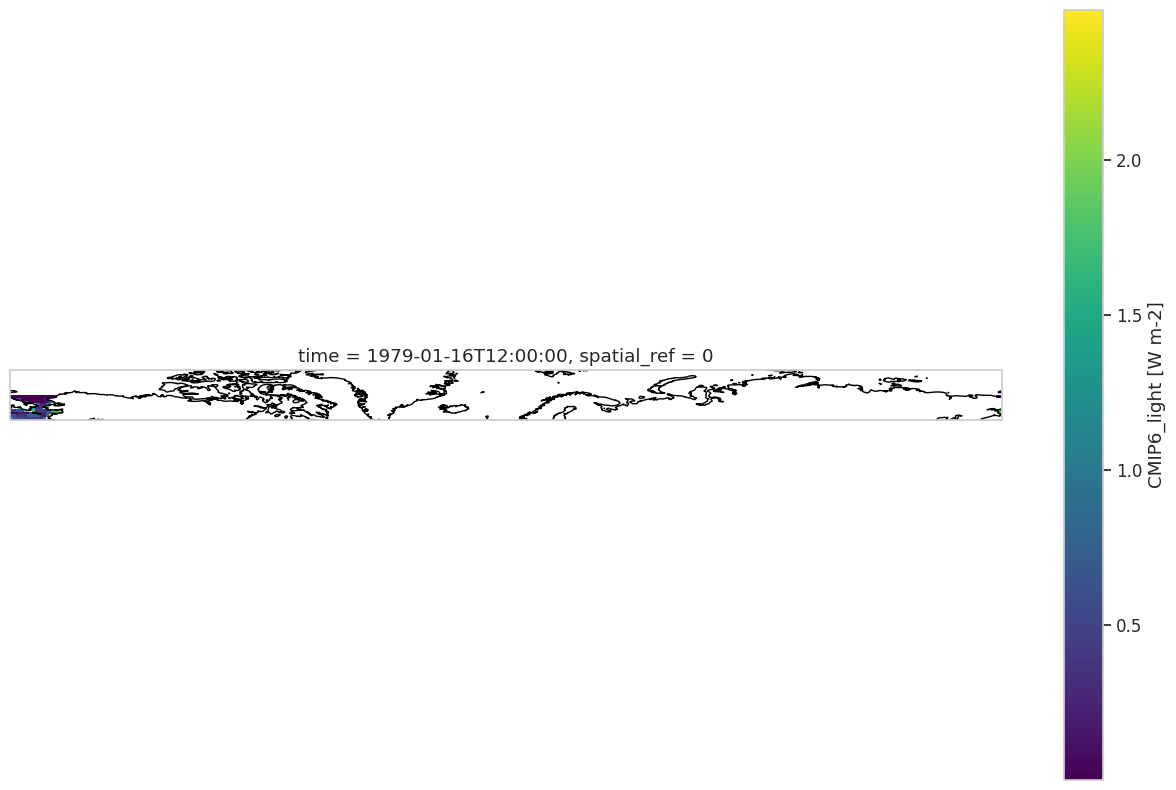

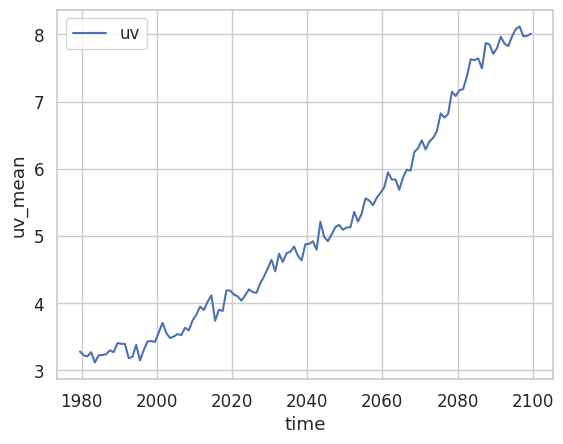

[CMIP6_IO] Opening file actea-shared/light/ncfiles/ensemble/CMIP6_ensemble_stats_ssp245_uva.nc
<xarray.Dataset>
Dimensions:    (lon: 360, lat: 25, time: 8709)
Coordinates:
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat        (lat) float64 60.5 61.5 62.5 63.5 64.5 ... 81.5 82.5 83.5 84.5
  * time       (time) datetime64[ns] 1979-01-16T12:00:00 ... 2099-12-16T20:00:00
Data variables:
    uva_mean   (time, lat, lon) float32 ...
    uva_stdev  (time, lat, lon) float32 ...
    uva_max    (time, lat, lon) float32 ...
    uva_min    (time, lat, lon) float32 ...
Attributes:
    title:        Test
    description:  Created for grid file:
    history:      Created 2023-09-16 22:54:41.737932\n[2023-09-30 17:29:50] :...
    link:         https://github.com/trondkr/model2roms
<xarray.Dataset>
Dimensions:    (lon: 360, lat: 25, time: 8709)
Coordinates:
  * lon        (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat        (lat) float64 60

<Figure size 640x480 with 0 Axes>

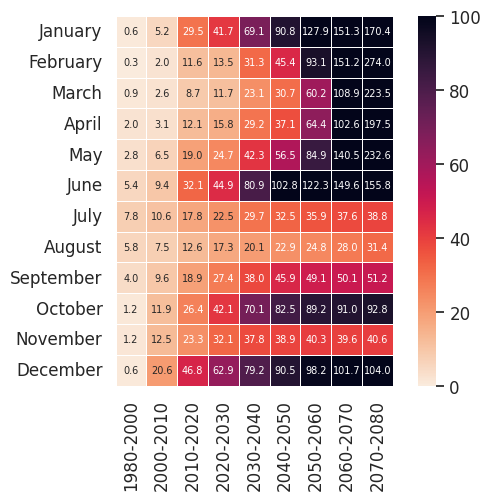

<Figure size 640x480 with 0 Axes>

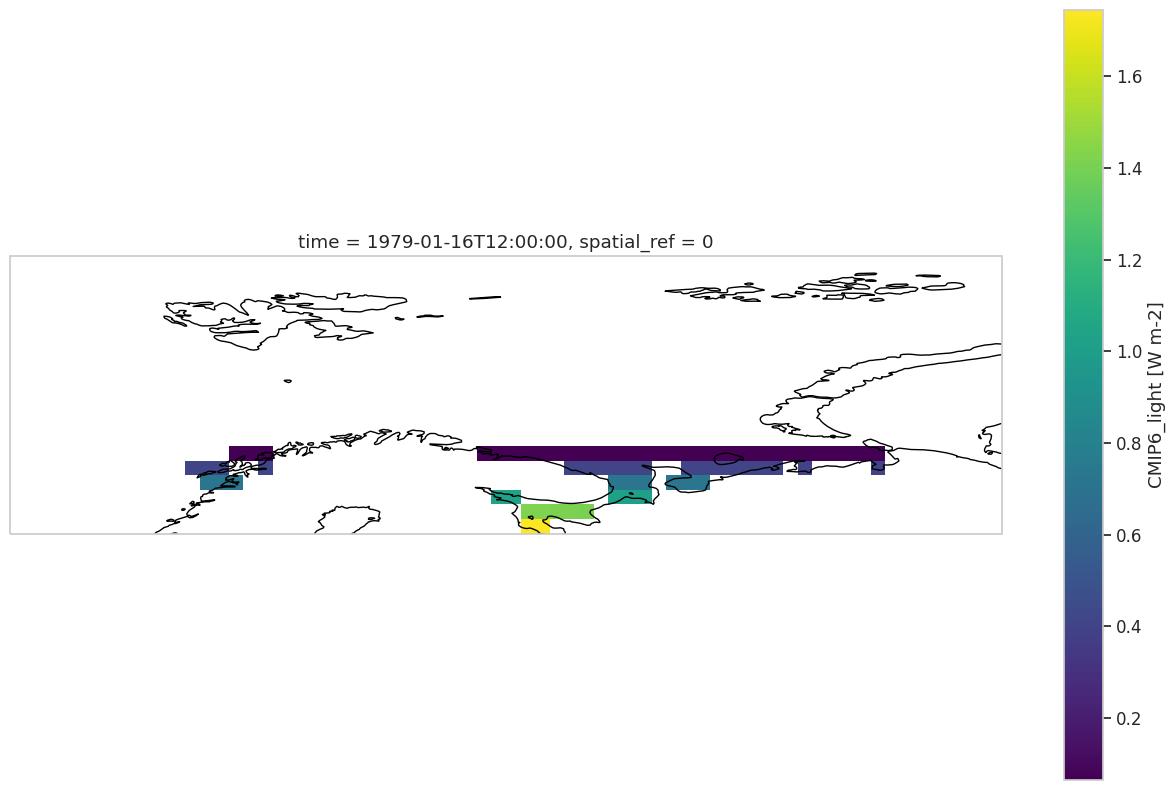

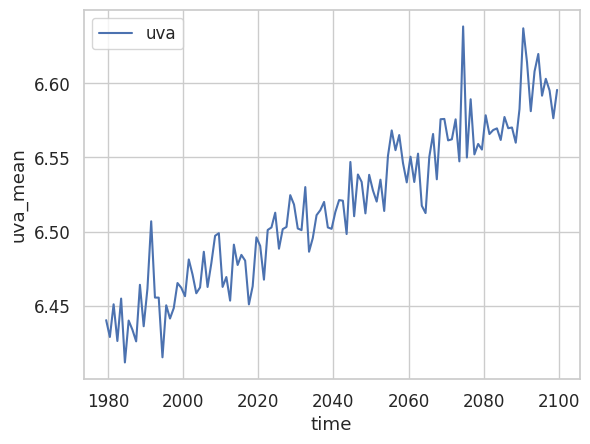

[CMIP6_IO] Opening file actea-shared/light/ncfiles/ensemble/CMIP6_ensemble_stats_ssp585_uva.nc
<xarray.Dataset>
Dimensions:    (lon: 360, lat: 25, time: 8709)
Coordinates:
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat        (lat) float64 60.5 61.5 62.5 63.5 64.5 ... 81.5 82.5 83.5 84.5
  * time       (time) datetime64[ns] 1979-01-16T12:00:00 ... 2099-12-16T20:00:00
Data variables:
    uva_mean   (time, lat, lon) float32 ...
    uva_stdev  (time, lat, lon) float32 ...
    uva_max    (time, lat, lon) float32 ...
    uva_min    (time, lat, lon) float32 ...
Attributes:
    title:        Test
    description:  Created for grid file:
    history:      Created 2023-09-17 08:53:30.120809\n[2023-09-30 17:33:07] :...
    link:         https://github.com/trondkr/model2roms
<xarray.Dataset>
Dimensions:    (lon: 360, lat: 25, time: 8709)
Coordinates:
  * lon        (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat        (lat) float64 60

<Figure size 640x480 with 0 Axes>

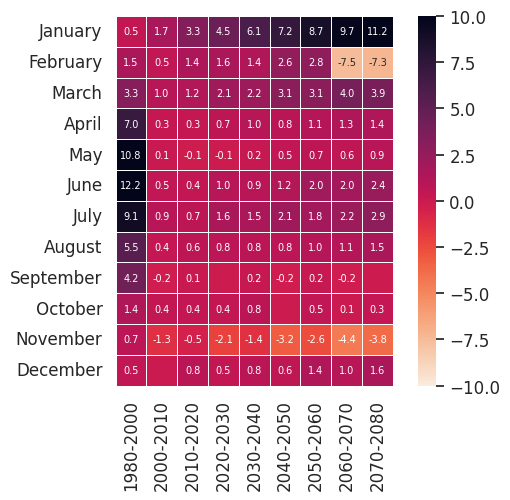

<Figure size 640x480 with 0 Axes>

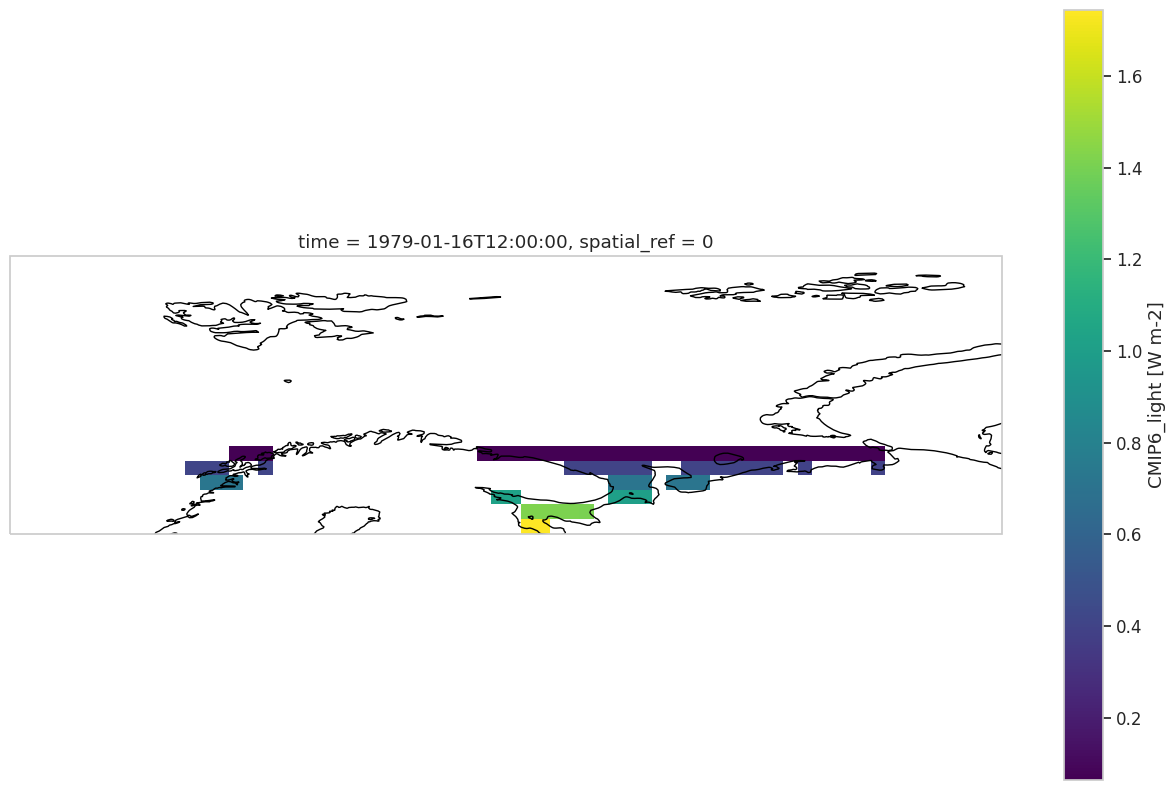

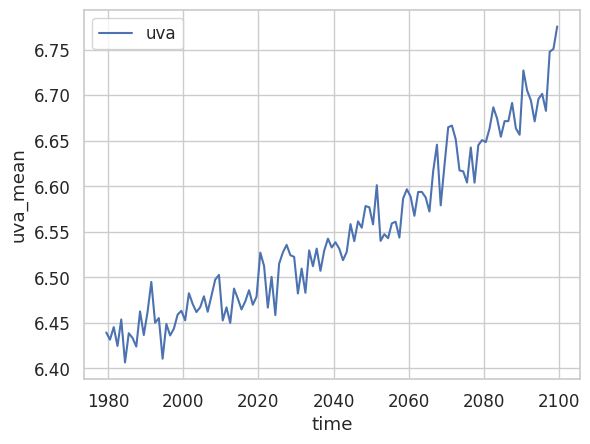

[CMIP6_IO] Opening file actea-shared/light/ncfiles/ensemble/CMIP6_ensemble_stats_ssp245_uva.nc
<xarray.Dataset>
Dimensions:    (lon: 360, lat: 25, time: 8709)
Coordinates:
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat        (lat) float64 60.5 61.5 62.5 63.5 64.5 ... 81.5 82.5 83.5 84.5
  * time       (time) datetime64[ns] 1979-01-16T12:00:00 ... 2099-12-16T20:00:00
Data variables:
    uva_mean   (time, lat, lon) float32 ...
    uva_stdev  (time, lat, lon) float32 ...
    uva_max    (time, lat, lon) float32 ...
    uva_min    (time, lat, lon) float32 ...
Attributes:
    title:        Test
    description:  Created for grid file:
    history:      Created 2023-09-16 22:54:41.737932\n[2023-09-30 17:29:50] :...
    link:         https://github.com/trondkr/model2roms
<xarray.Dataset>
Dimensions:    (lon: 360, lat: 25, time: 8709)
Coordinates:
  * lon        (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat        (lat) float64 60

<Figure size 640x480 with 0 Axes>

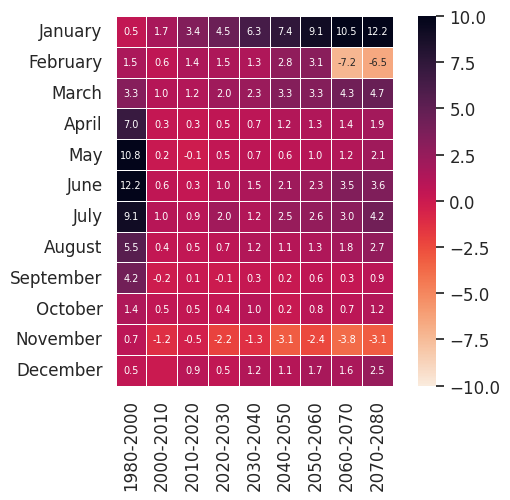

<Figure size 640x480 with 0 Axes>

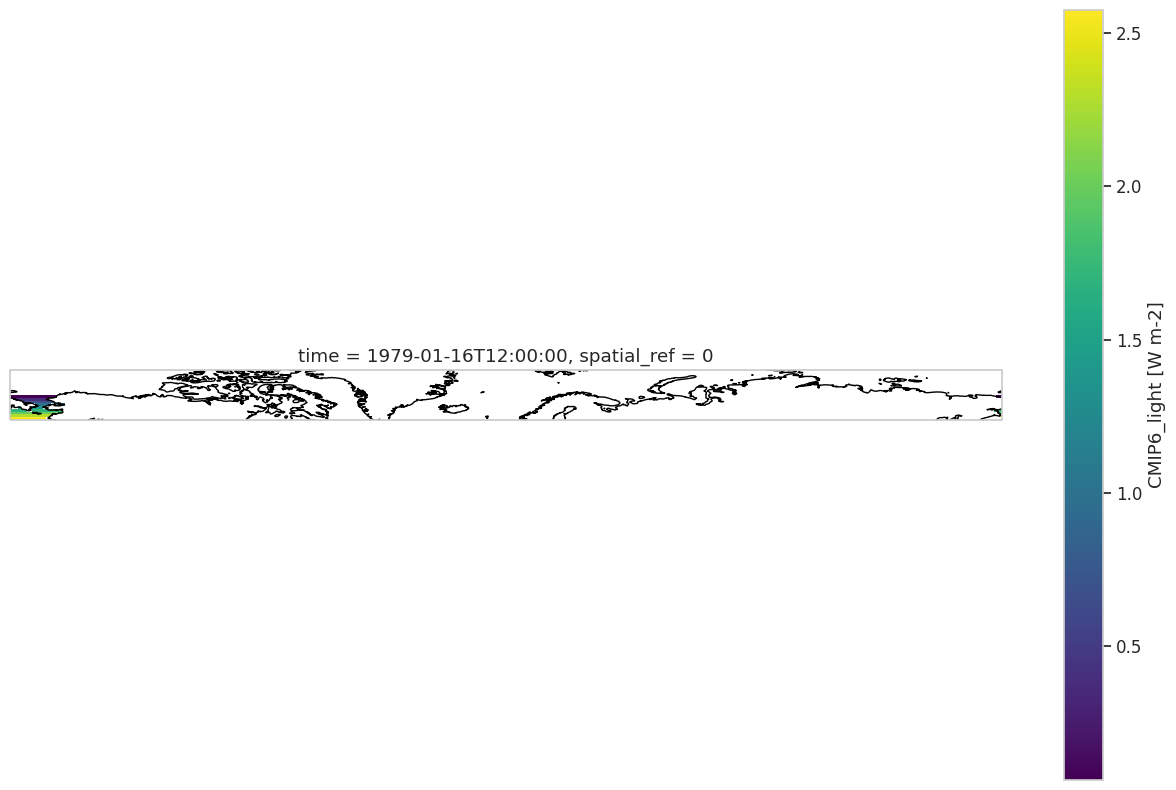

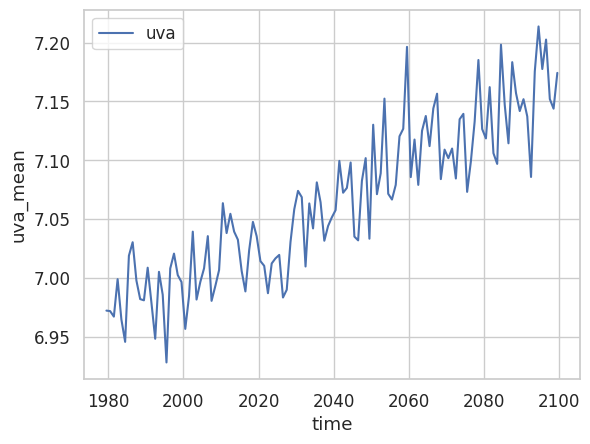

[CMIP6_IO] Opening file actea-shared/light/ncfiles/ensemble/CMIP6_ensemble_stats_ssp585_uva.nc
<xarray.Dataset>
Dimensions:    (lon: 360, lat: 25, time: 8709)
Coordinates:
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat        (lat) float64 60.5 61.5 62.5 63.5 64.5 ... 81.5 82.5 83.5 84.5
  * time       (time) datetime64[ns] 1979-01-16T12:00:00 ... 2099-12-16T20:00:00
Data variables:
    uva_mean   (time, lat, lon) float32 ...
    uva_stdev  (time, lat, lon) float32 ...
    uva_max    (time, lat, lon) float32 ...
    uva_min    (time, lat, lon) float32 ...
Attributes:
    title:        Test
    description:  Created for grid file:
    history:      Created 2023-09-17 08:53:30.120809\n[2023-09-30 17:33:07] :...
    link:         https://github.com/trondkr/model2roms
<xarray.Dataset>
Dimensions:    (lon: 360, lat: 25, time: 8709)
Coordinates:
  * lon        (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat        (lat) float64 60

<Figure size 640x480 with 0 Axes>

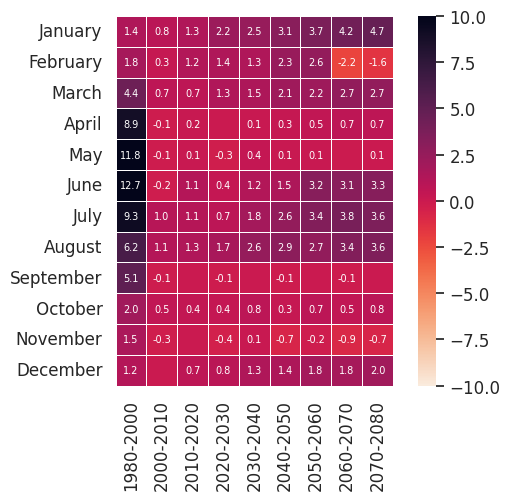

<Figure size 640x480 with 0 Axes>

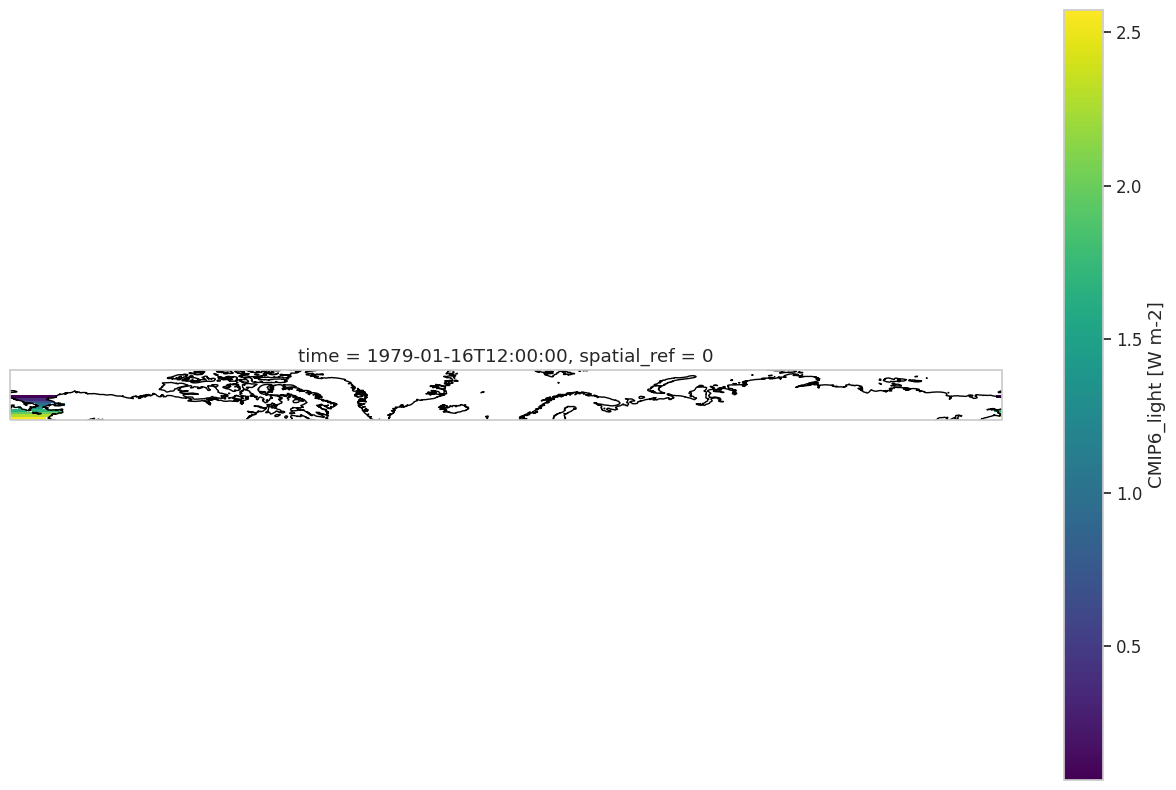

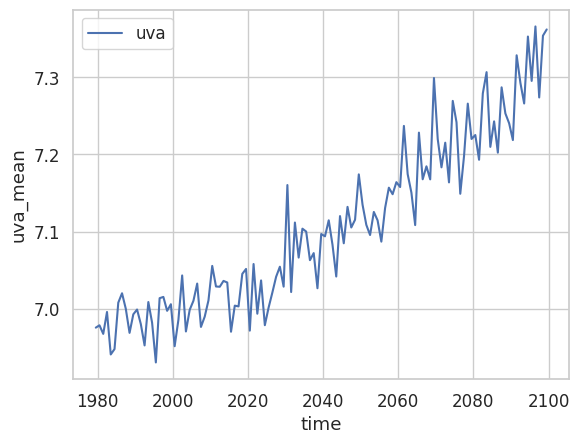

[CMIP6_IO] Opening file actea-shared/light/ncfiles/ensemble/CMIP6_ensemble_stats_ssp245_uvb.nc
<xarray.Dataset>
Dimensions:    (lon: 360, lat: 25, time: 8709)
Coordinates:
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat        (lat) float64 60.5 61.5 62.5 63.5 64.5 ... 81.5 82.5 83.5 84.5
  * time       (time) datetime64[ns] 1979-01-16T12:00:00 ... 2099-12-16T20:00:00
Data variables:
    uvb_mean   (time, lat, lon) float32 ...
    uvb_stdev  (time, lat, lon) float32 ...
    uvb_max    (time, lat, lon) float32 ...
    uvb_min    (time, lat, lon) float32 ...
Attributes:
    title:        Test
    description:  Created for grid file:
    history:      Created 2023-09-16 22:54:41.732308\n[2023-09-30 17:14:08] :...
    link:         https://github.com/trondkr/model2roms
<xarray.Dataset>
Dimensions:    (lon: 360, lat: 25, time: 8709)
Coordinates:
  * lon        (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat        (lat) float64 60

<Figure size 640x480 with 0 Axes>

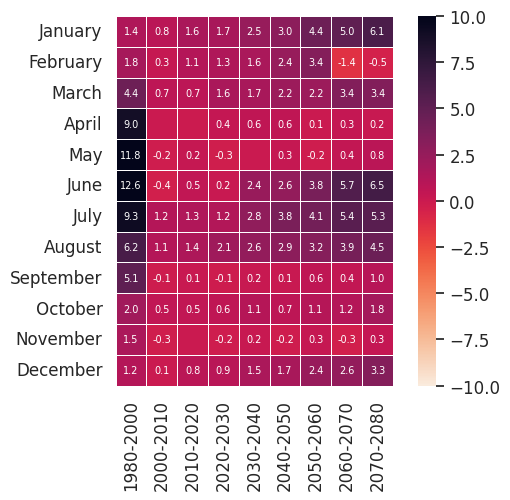

<Figure size 640x480 with 0 Axes>

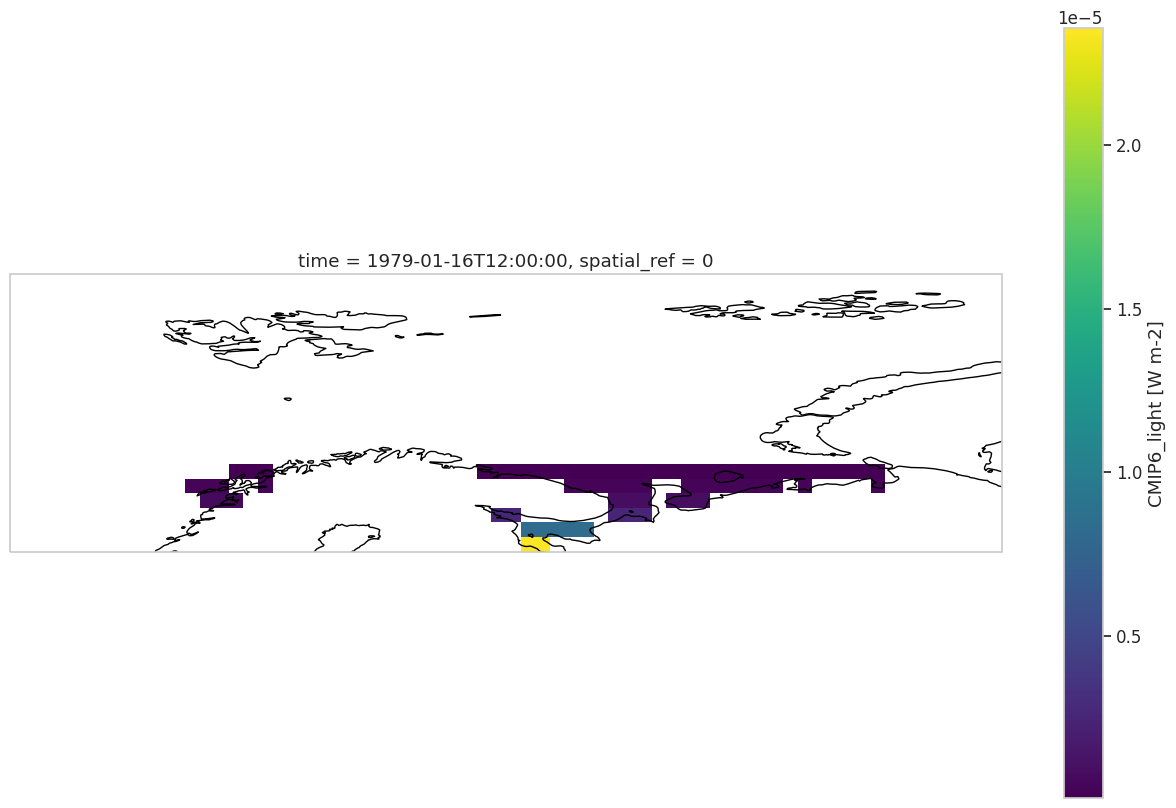

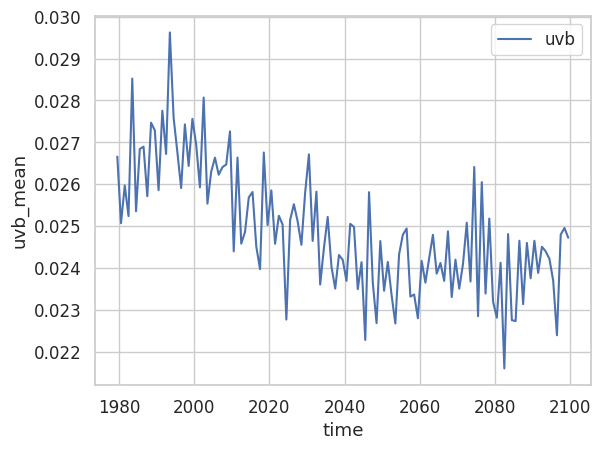

[CMIP6_IO] Opening file actea-shared/light/ncfiles/ensemble/CMIP6_ensemble_stats_ssp585_uvb.nc
<xarray.Dataset>
Dimensions:    (lon: 360, lat: 25, time: 8709)
Coordinates:
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat        (lat) float64 60.5 61.5 62.5 63.5 64.5 ... 81.5 82.5 83.5 84.5
  * time       (time) datetime64[ns] 1979-01-16T12:00:00 ... 2099-12-16T20:00:00
Data variables:
    uvb_mean   (time, lat, lon) float32 ...
    uvb_stdev  (time, lat, lon) float32 ...
    uvb_max    (time, lat, lon) float32 ...
    uvb_min    (time, lat, lon) float32 ...
Attributes:
    title:        Test
    description:  Created for grid file:
    history:      Created 2023-09-17 08:53:30.116083\n[2023-09-30 17:19:08] :...
    link:         https://github.com/trondkr/model2roms
<xarray.Dataset>
Dimensions:    (lon: 360, lat: 25, time: 8709)
Coordinates:
  * lon        (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat        (lat) float64 60

<Figure size 640x480 with 0 Axes>

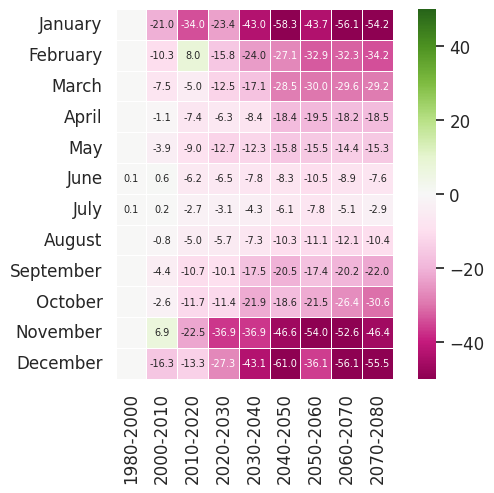

<Figure size 640x480 with 0 Axes>

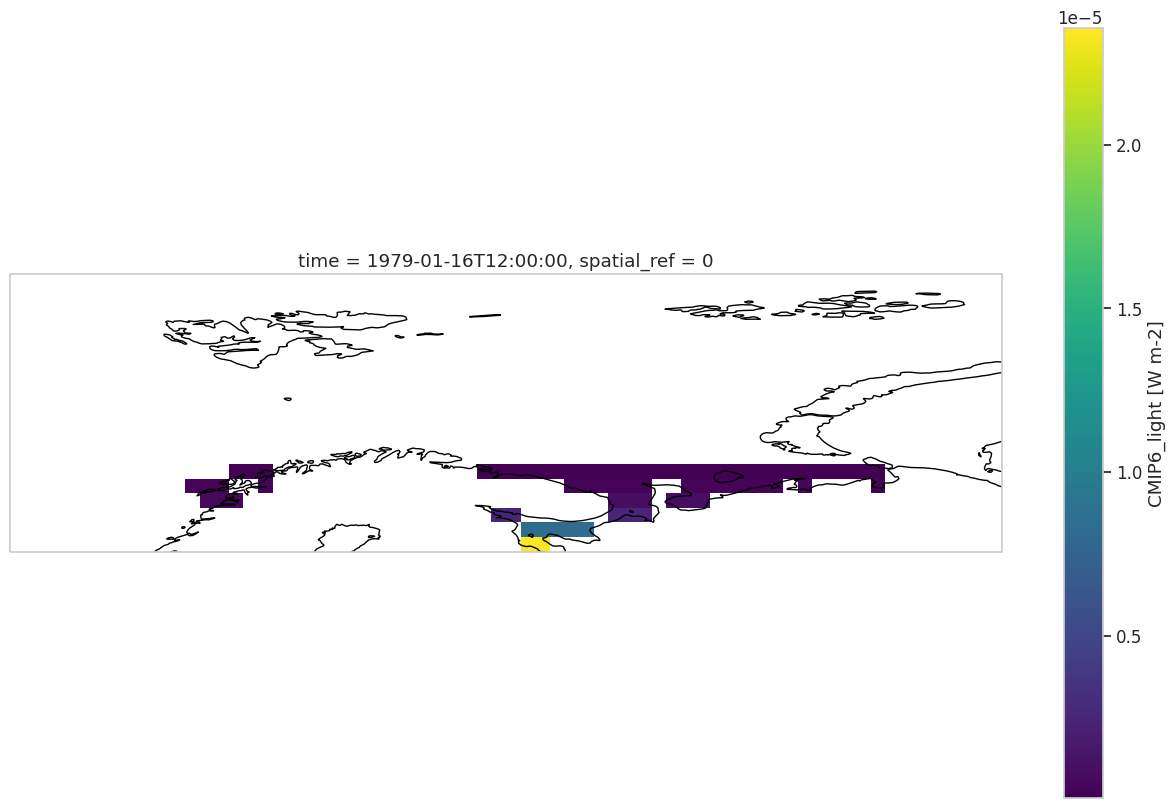

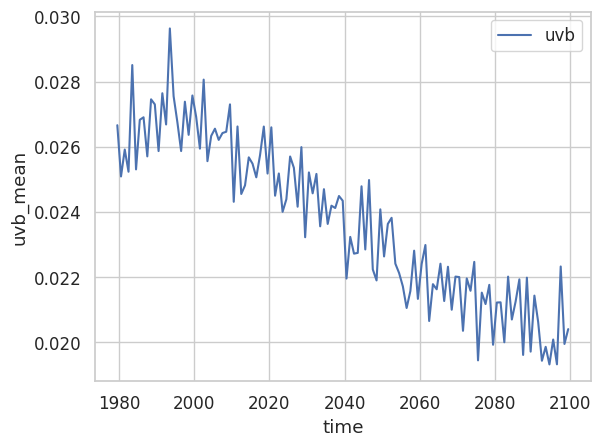

[CMIP6_IO] Opening file actea-shared/light/ncfiles/ensemble/CMIP6_ensemble_stats_ssp245_uvb.nc
<xarray.Dataset>
Dimensions:    (lon: 360, lat: 25, time: 8709)
Coordinates:
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat        (lat) float64 60.5 61.5 62.5 63.5 64.5 ... 81.5 82.5 83.5 84.5
  * time       (time) datetime64[ns] 1979-01-16T12:00:00 ... 2099-12-16T20:00:00
Data variables:
    uvb_mean   (time, lat, lon) float32 ...
    uvb_stdev  (time, lat, lon) float32 ...
    uvb_max    (time, lat, lon) float32 ...
    uvb_min    (time, lat, lon) float32 ...
Attributes:
    title:        Test
    description:  Created for grid file:
    history:      Created 2023-09-16 22:54:41.732308\n[2023-09-30 17:14:08] :...
    link:         https://github.com/trondkr/model2roms
<xarray.Dataset>
Dimensions:    (lon: 360, lat: 25, time: 8709)
Coordinates:
  * lon        (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat        (lat) float64 60

<Figure size 640x480 with 0 Axes>

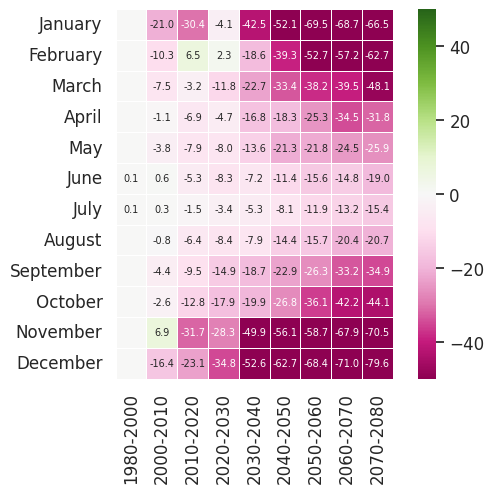

<Figure size 640x480 with 0 Axes>

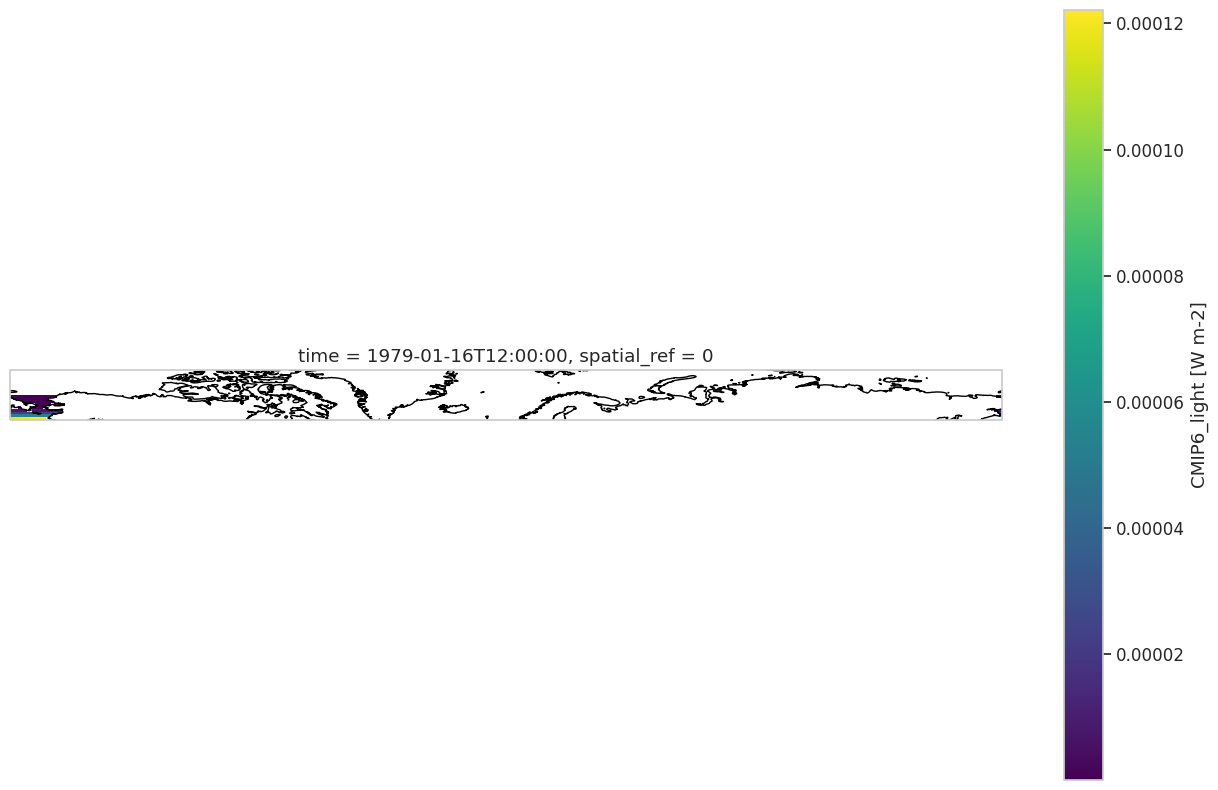

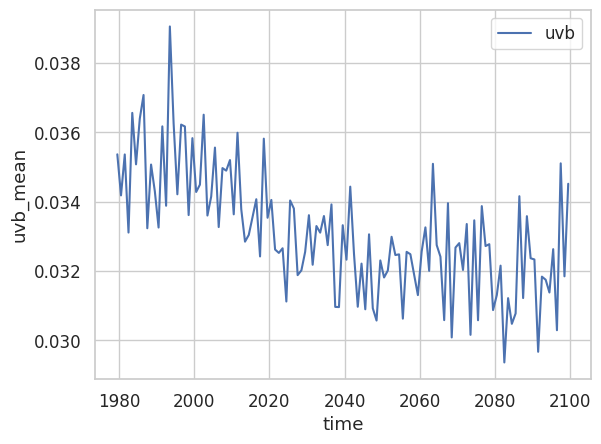

[CMIP6_IO] Opening file actea-shared/light/ncfiles/ensemble/CMIP6_ensemble_stats_ssp585_uvb.nc
<xarray.Dataset>
Dimensions:    (lon: 360, lat: 25, time: 8709)
Coordinates:
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat        (lat) float64 60.5 61.5 62.5 63.5 64.5 ... 81.5 82.5 83.5 84.5
  * time       (time) datetime64[ns] 1979-01-16T12:00:00 ... 2099-12-16T20:00:00
Data variables:
    uvb_mean   (time, lat, lon) float32 ...
    uvb_stdev  (time, lat, lon) float32 ...
    uvb_max    (time, lat, lon) float32 ...
    uvb_min    (time, lat, lon) float32 ...
Attributes:
    title:        Test
    description:  Created for grid file:
    history:      Created 2023-09-17 08:53:30.116083\n[2023-09-30 17:19:08] :...
    link:         https://github.com/trondkr/model2roms
<xarray.Dataset>
Dimensions:    (lon: 360, lat: 25, time: 8709)
Coordinates:
  * lon        (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat        (lat) float64 60

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

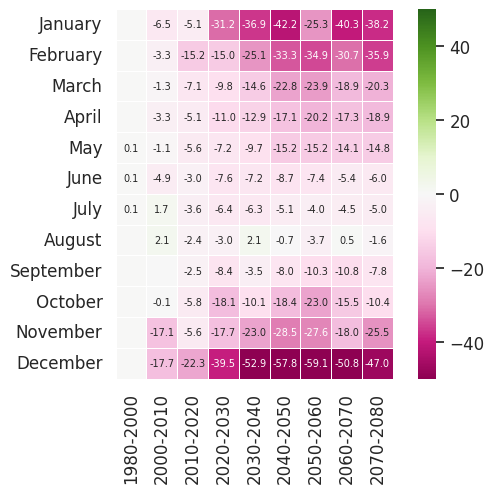

In [5]:
scenarios = ["ssp245", "ssp585"]  # , "ssp585"]
period = "1979-01-01-2099-12-16"
start_time = "1979-01-01"
end_time = "2099-12-16"


# This script is created only to plot the seasonal mismatch in the
# future of chlorophyll.
# ["tas","par","uv","uva","uvb","uvi","chl"]
ds_var_names = [
    "par",
    "uv",
    "uva",
    "uvb",
    "uvi",
    "clt",
    "siconc",
    "sisnthick",
    "sithick",
    "chl",
    "tos",
    "tas",
]
# ds_var_names = ["siconc"] #,"uva","clt","siconc","sisnthick","sithick"]


seasonal = False
cumulative = False
LMES = ["Barents Sea", "Northern Bering - Chukchi Seas"]
# LMES = ['Northern Bering - Chukchi Seas']

for var_name in ds_var_names:
    for LME in LMES:
        models_dict = {}
        # We loop over all scenarios, ensemble_ids, and models to create a
        # list of dataframes that we eventually concatenate together and plot
        for scenario in scenarios:
            ds_list = []
            if var_name in [
                "tos",
                "chl",
                "tas",
                "clt",
                "siconc",
                "sisnthick",
                "sithick",
            ]:
                fname = f"light/{scenario}/ensemble/CMIP6_ensemble_{scenario}_{var_name}_weighted.nc"
            else:
                fname = f"light/ncfiles/ensemble/CMIP6_ensemble_stats_{scenario}_{var_name}.nc"

            ds = io.open_dataset_on_gs(fname)

            models_dict, ens_stats = get_area_averaged_ds(
                ds,
                "ensemble",
                scenario,
                "ensemble",
                var_name,
                LME,
                models_dict,
                start_time,
                end_time,
            )
            outfile = f"Figures/{var_name}_ensemble_{scenario}_{LME}.png"
            print(ens_stats)
            if ens_stats is not None:
                fig = plt.figure()
                # Create timeseries plots
                var_name_ens = f"{var_name}_mean"
                if LME in ["Barents Sea"]:
                    ax = plt.figure(figsize=(16, 10)).gca(
                        projection=ccrs.PlateCarree(central_longitude=0)
                    )
                else:
                    ax = plt.figure(figsize=(16, 10)).gca(
                        projection=ccrs.PlateCarree(central_longitude=0)
                    )
                ens_stats[var_name_ens].isel(time=0).plot(ax=ax)
                ax.coastlines()

                plt.show()
                sns.lineplot(
                    x=ens_stats.time.resample(time="A").mean(),
                    y=var_name_ens,
                    data=ens_stats.mean({"lat", "lon"}).resample(time="A").mean(),
                    label=f"{var_name}",
                )

                plt.legend()
                plt.show()
                plt.clf()
                # Create heatmaps
                df = ens_stats.to_dataframe().reset_index()
                start_times = [datetime(1980, 1, 1)]
                end_times = [datetime(2000, 1, 1)]

                step = 10
                # TODO: Add longer historical period by joining two lists.
                start_times.extend(
                    [datetime(2000 + i, 1, 1) for i in range(0, 80, step)]
                )
                end_times.extend(
                    [datetime(2000 + step + i, 1, 1) for i in range(0, 80, step)]
                )

                labels = []
                dfs = []

                max_df_dict = {}
                if seasonal:
                    frequency = "season"
                else:
                    frequency = "month"

                for start, end in zip(start_times, end_times):
                    label = f"{start.year}-{end.year}"
                    labels.append(label)

                    df = CMIP6_ridgeplot.return_df_climatology(
                        var_name_ens,
                        None,
                        start_time=start,
                        end_time=end,
                        depth_threshold=None,
                        ds=ens_stats,
                        cumulative=cumulative,
                        seasonal=seasonal,
                    ).reset_index(level=frequency)

                    df.set_index("month", inplace=True)
                    dfs.append(df)
                    max_df_dict[label] = df[var_name_ens].groupby("month").mean()

                fig = plt.figure()
                CMIP6_ridgeplot.heatmap_of_change(
                    max_df_dict, var_name_ens, labels, 12, LME, scenario
                )
                # plt.show()